## 1. Searching for inside HTML files

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
import os

html_tables = {}

# For every table in the datasets folder...
for table_name in os.listdir('datasets'):
    table_path = f'datasets/{table_name}'
    # Open as a python file in read-only mode
    table_file = open(table_path, 'r')
    # Read the contents of the file into 'html'
    html = BeautifulSoup(table_file)
    # Find 'news-table' in the Soup and load it into 'html_table'
    html_table = html.find(id='news-table')
    # Add the table to our dictionary
    html_tables[table_name] = html_table

## 2. What is inside those files anyway?

In [2]:
# Read one single day of headlines 
tsla = html_tables['CTS_20230923.html']
# Get all the table rows tagged in HTML with <tr> into 'tesla_tr'
tsla_tr = tsla.findAll('tr')

# For each row...
for i, table_row in enumerate(tsla_tr):
    # Read the text of the element 'a' into 'link_text'
    link_text = table_row.a.get_text()
    # Read the text of the element 'td' into 'data_text'
    data_text = table_row.td.get_text()
    # Print the count
    print(f'File number {i+1}:')
    # Print the contents of 'link_text' and 'data_text' 
    print(link_text)
    print(data_text)
    if i == 3:
        break

File number 1:
Sidoti Events, LLCs Virtual September Small-Cap Conference

            Sep-19-23 09:00AM
        
File number 2:
CTS Corporation to Participate in Sidoti Virtual Investor Conference

            Sep-15-23 09:37AM
        
File number 3:
CTS Corporation Declares a Dividend

            Aug-17-23 04:15PM
        
File number 4:
Should You Be Confident in CTS Corporation (CTS)s Market Share Position?

            Aug-03-23 10:24AM
        


## 3.  Extract the news headlines

In [3]:
# Hold the parsed news into a list
parsed_news = []
# Iterate through the news
for file_name, news_table in html_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the /text in the td tag into a list 
        date_scrape = x.td.text.split()
        # If the length of 'date_scrape' is 1, load 'time' as the only element
        # If not, load 'date' as the 1st element and 'time' as the second
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split("_")[0]
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, x.a.text])

## 4. Make NLTK 

In [4]:
import nltk
#nltk.download('vader_lexicon')
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}

# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()

# Update the lexicon
vader.lexicon.update(new_words)

## 5. NLTK  Sentiment Estimates


In [5]:
import pandas as pd

# Use these column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the list of lists into a DataFrame
scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores
scores = [vader.polarity_scores(head) for head in scored_news.headline]

# Convert the list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames
scored_news = scored_news.join(scores_df)

# Convert the date column from string to datetime
scored_news['date'] = pd.to_datetime(scored_news.date).dt.date

## EDA handing duplicates

In [6]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = scored_news.headline.count()

# Drop duplicates based on ticker and headline
scored_news_clean = scored_news.drop_duplicates(subset= ['headline', 'ticker'])

# Count number of headlines after dropping duplicates
num_news_after = scored_news_clean.headline.count()

# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 3719 headlines, now we have 3504'

In [7]:
scored_news_clean.headline.isnull().sum()

0

In [8]:
import pandas as pd
df = scored_news_clean
# Convert the 'date' column to string
df['date'] = df['date'].astype(str)

In [9]:
scored_news_clean.head(5)

,ticker,date,time,headline,neg,neu,pos,compound
0,AAAU.html,2022-08-18,01:40PM,Best Gold ETFs for Q4 2022,0.0,0.543,0.457,0.6369
1,AAAU.html,2022-01-19,05:50PM,Goldman Sachs Asset Management Announces Trans...,0.0,0.872,0.128,0.3612
2,AAAU.html,2020-12-14,01:30PM,Goldman Takes Over Gold ETF,0.0,1.000,0.000,0.0000
3,AAAU.html,2020-12-14,08:00AM,Goldman Sachs Asset Management Announces Addit...,0.0,0.865,0.135,0.3612
4,AAAU.html,2020-08-11,01:14PM,Best Precious Metals ETFs for Q4 2020,0.0,0.388,0.612,0.8360


In [10]:
scored_news_clean.ticker.value_counts()

tsla                                                                                  286
fb                                                                                    190
dell.html                                                                             100
XAIR - Beyond Air, Inc. Stock Price and Quote.html                                     99
F - Ford Motor Company Stock Price and Quote.html                                      99
Z - Zillow Group, Inc. Stock Price and Quote.html                                      99
V - Visa Inc. Stock Price and Quote.html                                               98
YETI.html                                                                              98
M - Macy's, Inc. Stock Price and Quote.html                                            97
CAPR.html                                                                              97
MSFT.html                                                                              97
EA - Elect

In [11]:
single_day = scored_news_clean.set_index(['ticker', 'date'])
single_day.head(14)

time  \
ticker    date                  
AAAU.html 2022-08-18  01:40PM   
          2022-01-19  05:50PM   
          2020-12-14  01:30PM   
          2020-12-14  08:00AM   
          2020-08-11  01:14PM   
          2020-06-26  12:10PM   
          2020-05-18  12:08PM   
          2020-02-05  07:21AM   
          2019-08-26  11:02AM   
          2019-08-06  06:29PM   
          2019-08-06  02:56PM   
          2019-07-17  01:35PM   
          2019-07-16  11:42AM   
          2019-06-20  09:00AM   

                                                               headline  neg  \
ticker    date                                                                 
AAAU.html 2022-08-18                         Best Gold ETFs for Q4 2022  0.0   
          2022-01-19  Goldman Sachs Asset Management Announces Trans...  0.0   
          2020-12-14                        Goldman Takes Over Gold ETF  0.0   
          2020-12-14  Goldman Sachs Asset Management Announces Addit...  0.0   
          2020-08-11              Best Precious Metals ETFs for Q4 2020  0.0   
          2020-06-26      Gold Beats Stocks & Bonds in 1H: ETFs to Play  0.0   
          2020-05-18   What Are Some Safe Investment Options Right Now?  0.0   
          2020-02-05         Thank ETF investors for higher gold prices  0.0   
          2019-08-26      Say GDay To Gold ETF AAAU Backed by Australia  0.0   
          2019-08-06                      Should You Buy Gold ETFs Now?  0.0   
          2019-08-06          Gold ETFs & the World's Largest Gold Coin  0.0   
          2019-07-17  NYSE Greets Huge Gold Coin to Showcase Perth M...  0.0   
          2019-07-16     The Perth Mint to Ring NYSE Closing Bell Today  0.0   
          2019-06-20  The Perth Mint Physical Gold ETF Recruits Comm...  0.0   

                        neu    pos  compound  
ticker    date                                
AAAU.html 2022-08-18  0.543  0.457    0.6369  
          2022-01-19  0.872  0.128    0.3612  
          2020-12-14  1.000  0.000    0.0000  
          2020-12-14  0.865  0.135    0.3612  
          2020-08-11  0.388  0.612    0.8360  
          2020-06-26  0.455  0.545    0.8555  
          2020-05-18  0.707  0.293    0.4404  
          2020-02-05  0.706  0.294    0.3612  
          2019-08-26  0.879  0.121    0.0258  
          2019-08-06  1.000  0.000    0.0000  
          2019-08-06  1.000  0.000    0.0000  
          2019-07-17  0.672  0.328    0.4404  
          2019-07-16  1.000  0.000    0.0000  
          2019-06-20  0.612  0.388    0.7650

In [15]:
# Take user input for stock_name and date
stock_name = input("Enter the stock name: ")
S_date = input("Enter the date (yyyy-mm-dd): ")
# Display the user inputs
print("Stock Name:", stock_name)
print("Date:", S_date)

Enter the stock name: AAAU.html
Enter the date (yyyy-mm-dd): 2020-12-14
Stock Name: AAAU.html
Date: 2020-12-14


## 8. EDA-Sentiment on one single trading day and stock


In [16]:
# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# Cross-section the 'fb' row
single_day = single_day.xs(stock_name, drop_level=False)  # Use drop_level=False to keep the 'ticker' level in the index

# Specify the date you want to select
selected_date =S_date

if selected_date in single_day.index.get_level_values('date'):
    # Select rows with the specified date
    single_day = single_day.loc[(slice(None), selected_date), :]

    # Convert the 'time' column to datetime.time objects
    single_day['time'] = pd.to_datetime(single_day['time']).dt.time

    # Set 'time' as the new index
    single_day = single_day.set_index('time')

    # Sort the DataFrame by the new index
    single_day = single_day.sort_index()
else:
    # Handle the case when the date is not found
    print(f"Date '{selected_date}' not found in the index. No data available for this date and stock.")

# 9. EDA-Visualize the single day and outcome 1:
We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock.

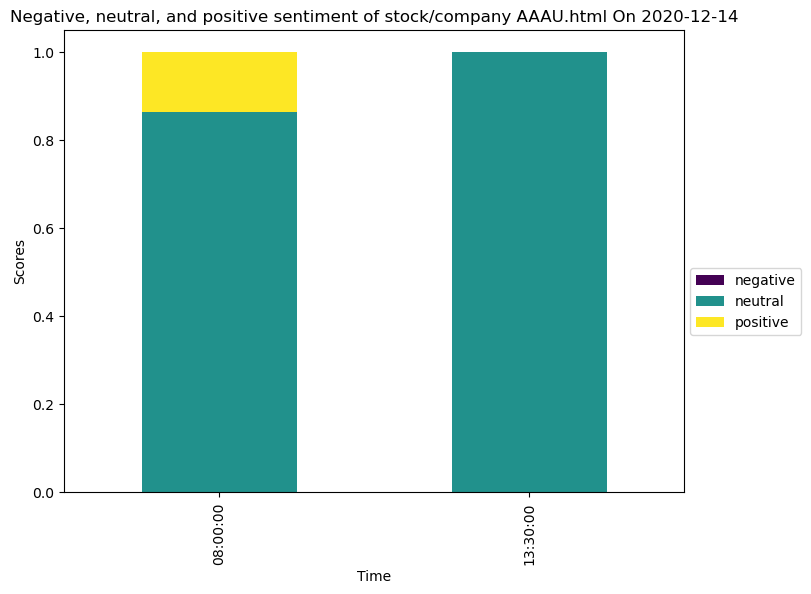

In [17]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2020-12-14"
COLORS = ["red","orange", "green"]

# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], 1)

# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']

# Plot a stacked bar chart
import matplotlib.pyplot as plt

# Define the title and colors
TITLE="Negative, neutral, and positive sentiment of stock/company " + stock_name+" " +"On "+ S_date
COLORS = ["red", "orange", "green"]

# Create a stacked bar plot
ax = plot_day.plot(kind='bar', stacked=True, figsize=(8,6), colormap='viridis')
plt.title(TITLE)
plt.xlabel('Time')
plt.ylabel('Scores')

# Customize the legend location
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

# Show the plot
plt.show()

# preprocessing and model building

### Creating new dataframe with date and headline only

In [18]:
stock_df= scored_news_clean.drop(["date","ticker","time","neg","neu","pos","compound"], axis=1)

In [19]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3718
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  3504 non-null   object
dtypes: object(1)
memory usage: 54.8+ KB


In [20]:
stock_df.head(3)

,headline
0,Best Gold ETFs for Q4 2022
1,Goldman Sachs Asset Management Announces Trans...
2,Goldman Takes Over Gold ETF


In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# create sentiment intensity analyzer object
SIA = SentimentIntensityAnalyzer()

In [22]:
def mapper(data):
    if data > 0:
        return "Positive"
    elif data < 0:
        return "Negative"
    else:
        return "Neutral"

def sentiment_analysis(stock_df):
    
    # assigning polarity scores for description column
    stock_df['polarity_scores'] = stock_df["headline"].apply(lambda w: SIA.polarity_scores(w))
    
    # picking only compound score(combined score)
    stock_df['compound_score'] = stock_df['polarity_scores'].apply(lambda x: x['compound'])
    
    # mapping the compound score to positive, negative or neutral
    stock_df['sentiment_score'] = stock_df['compound_score'].apply(mapper)
    
    stock_df.drop(['polarity_scores', 'compound_score'], axis=1, inplace=True)
    return stock_df

In [23]:
print(sentiment_analysis(stock_df))

                                               headline sentiment_score
0                            Best Gold ETFs for Q4 2022        Positive
1     Goldman Sachs Asset Management Announces Trans...        Positive
2                           Goldman Takes Over Gold ETF         Neutral
3     Goldman Sachs Asset Management Announces Addit...        Positive
4                 Best Precious Metals ETFs for Q4 2020        Positive
...                                                 ...             ...
3714  Zapp Electric Vehicles ($ZAPP) i300 EV Urban M...        Positive
3715  Zapp Secures Twin Patents For Innovative i300 ...        Positive
3716  Zapp Appoints Production Veteran as Operations...         Neutral
3717  Zapp Appoints Mark Kobal as Head of Investor R...         Neutral
3718  Zapp Celebrates Successful Listing on the Nasd...        Positive

[3504 rows x 2 columns]


# Data random sampling

In [24]:
from sklearn.model_selection import train_test_split

X = stock_df['headline']
y = stock_df.sentiment_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3153,) (351,) (3153,) (351,)


# LinearSVC

In [25]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report,f1_score

lin_svc_ds = Pipeline([('tfidf', TfidfVectorizer()),
                      ('lin_svc', LinearSVC())])
lin_svc_ds.fit(X_train, y_train)
pred = lin_svc_ds.predict(X_test)

print("MODEL: LINEAR SVC")
print("accuarcy score: ", accuracy_score(y_test, pred))
print("Confusion matrix: ", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))



MODEL: LINEAR SVC
accuarcy score:  0.8176638176638177
Confusion matrix:  [[ 24  14  10]
 [  1 157  13]
 [  7  19 106]]
              precision    recall  f1-score   support

    Negative       0.75      0.50      0.60        48
     Neutral       0.83      0.92      0.87       171
    Positive       0.82      0.80      0.81       132

    accuracy                           0.82       351
   macro avg       0.80      0.74      0.76       351
weighted avg       0.81      0.82      0.81       351



## Logistic Regression


In [26]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

logistic_regression_ds = Pipeline([('tfidf', TfidfVectorizer()),
                                   ('logistic_regression', LogisticRegression())])
logistic_regression_ds.fit(X_train, y_train)
pred = logistic_regression_ds.predict(X_test)

print("MODEL: LOGISTIC REGRESSION")
print("accuracy score: ", accuracy_score(y_test, pred))
print("Confusion matrix: ", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


MODEL: LOGISTIC REGRESSION
accuracy score:  0.7806267806267806
Confusion matrix:  [[ 16  16  16]
 [  0 161  10]
 [  6  29  97]]
              precision    recall  f1-score   support

    Negative       0.73      0.33      0.46        48
     Neutral       0.78      0.94      0.85       171
    Positive       0.79      0.73      0.76       132

    accuracy                           0.78       351
   macro avg       0.77      0.67      0.69       351
weighted avg       0.78      0.78      0.76       351

CPU times: total: 1.69 s
Wall time: 545 ms


## support vector machine

In [27]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

svm_ds = Pipeline([('tfidf', TfidfVectorizer()),
                   ('svm', SVC())])
svm_ds.fit(X_train, y_train)
pred = svm_ds.predict(X_test)

print("MODEL: SUPPORT VECTOR MACHINE (SVM)")
print("accuracy score: ", accuracy_score(y_test, pred))
print("Confusion matrix: ", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


MODEL: SUPPORT VECTOR MACHINE (SVM)
accuracy score:  0.7578347578347578
Confusion matrix:  [[ 12  21  15]
 [  0 161  10]
 [  5  34  93]]
              precision    recall  f1-score   support

    Negative       0.71      0.25      0.37        48
     Neutral       0.75      0.94      0.83       171
    Positive       0.79      0.70      0.74       132

    accuracy                           0.76       351
   macro avg       0.75      0.63      0.65       351
weighted avg       0.76      0.76      0.74       351

CPU times: total: 2.47 s
Wall time: 2.06 s


## Random Forest

In [28]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

random_forest_ds = Pipeline([('tfidf', TfidfVectorizer()),
                             ('random_forest', RandomForestClassifier())])
random_forest_ds.fit(X_train, y_train)
pred = random_forest_ds.predict(X_test)

print("MODEL: RANDOM FOREST")
print("accuracy score: ", accuracy_score(y_test, pred))
print("Confusion matrix: ", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


MODEL: RANDOM FOREST
accuracy score:  0.7891737891737892
Confusion matrix:  [[ 18  22   8]
 [  1 169   1]
 [  5  37  90]]
              precision    recall  f1-score   support

    Negative       0.75      0.38      0.50        48
     Neutral       0.74      0.99      0.85       171
    Positive       0.91      0.68      0.78       132

    accuracy                           0.79       351
   macro avg       0.80      0.68      0.71       351
weighted avg       0.81      0.79      0.77       351

CPU times: total: 9.11 s
Wall time: 9.16 s


## KNeighborsClassifier

In [29]:
%%time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

naive_bayes_ds = Pipeline([('tfidf', TfidfVectorizer()),
                           ('naive_bayes', MultinomialNB())])
naive_bayes_ds.fit(X_train, y_train)
pred = naive_bayes_ds.predict(X_test)

print("MODEL: NAIVE BAYES")
print("accuracy score: ", accuracy_score(y_test, pred))
print("Confusion matrix: ", confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


MODEL: NAIVE BAYES
accuracy score:  0.698005698005698
Confusion matrix:  [[  3  24  21]
 [  0 151  20]
 [  1  40  91]]
              precision    recall  f1-score   support

    Negative       0.75      0.06      0.12        48
     Neutral       0.70      0.88      0.78       171
    Positive       0.69      0.69      0.69       132

    accuracy                           0.70       351
   macro avg       0.71      0.54      0.53       351
weighted avg       0.70      0.70      0.66       351

CPU times: total: 93.8 ms
Wall time: 87 ms


## xgboost

In [30]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import Pipeline

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable into integer labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Use the encoded target variable in your XGBoost pipeline
xgboost_ds = Pipeline([('tfidf', TfidfVectorizer()),
                       ('xgboost', XGBClassifier())])
xgboost_ds.fit(X_train, y_train_encoded)
pred_encoded = xgboost_ds.predict(X_test)

# Inverse transform the predictions to get the original class labels
pred = label_encoder.inverse_transform(pred_encoded)

# Now you can calculate accuracy and other metrics
accuracy = accuracy_score(y_test, pred)
# ... rest of your code for metrics and reporting

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Negative       0.82      0.48      0.61        48
     Neutral       0.75      0.94      0.84       171
    Positive       0.83      0.70      0.76       132

    accuracy                           0.78       351
   macro avg       0.80      0.70      0.73       351
weighted avg       0.79      0.78      0.77       351



## GradientBoostingClassifier

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable into integer labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Use the encoded target variable in your Gradient Boosting pipeline
gradient_boosting_ds = Pipeline([('tfidf', TfidfVectorizer()),
                                  ('gradient_boosting', GradientBoostingClassifier())])
gradient_boosting_ds.fit(X_train, y_train_encoded)
pred_encoded = gradient_boosting_ds.predict(X_test)

# Inverse transform the predictions to get the original class labels
pred = label_encoder.inverse_transform(pred_encoded)

# Now you can calculate accuracy and other metrics
accuracy = accuracy_score(y_test, pred)
# ... rest of your code for metrics and reporting

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

    Negative       0.76      0.33      0.46        48
     Neutral       0.70      0.99      0.82       171
    Positive       0.93      0.61      0.74       132

    accuracy                           0.76       351
   macro avg       0.80      0.65      0.67       351
weighted avg       0.80      0.76      0.74       351



# ----------------------------------lets predict on XGboost---------------------------------

In [33]:
sentiment = [' Best Precious Metals ETFs for Q4 2020']
y_predict = xgboost_ds.predict(sentiment)
pred = label_encoder.inverse_transform(y_predict)
print(pred)

['Positive']


In [34]:
sentiment = [' Zapp Appoints Mark Kobal as Head of Investor']
y_predict = xgboost_ds.predict(sentiment)
pred = label_encoder.inverse_transform(y_predict)
print(pred)

['Neutral']
